# Read in the data

In [44]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [45]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [46]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string = str(num)
    if len(string) > 1:
        return string
    else:
        return "0" + string
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [47]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [48]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [49]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [50]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [51]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [52]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Survey and SAT score correlations

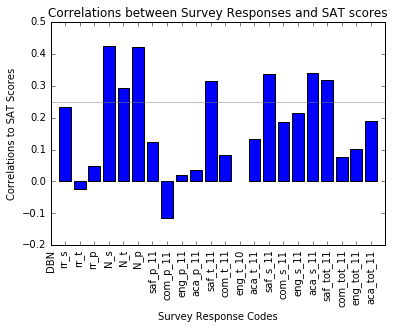

In [53]:
%matplotlib inline

pos = np.arange(len(survey_fields))
plt.bar(pos, correlations[survey_fields], align = 'center')
plt.xticks(pos, survey_fields, rotation=90)
plt.axhline(.25, c = "gray", alpha = 0.5)
plt.xlim(0, len(survey_fields))
plt.title("Correlations between Survey Responses and SAT scores")
plt.xlabel("Survey Response Codes")
plt.ylabel("Correlations to SAT Scores")
plt.show()

The first thing I notice is that most of these responses have positive correlations, even if they aren't strong. I put a line at .25, and will look at the 7 factors that surpass it. 

N_s (number of eligible students) and N_p (Number of eligible parents) are by far the strongest correlations. This would inidicate that larger schools with more students (and therefore parents) correlate to SAT scores. The N_t (number of teachers) still counts as a significant correlation, but is not as high of one. Which is surprising. I would guess that the more teachers that are available to teach and offer 1-on-1 support would correlate to higher scores and lack of that would correlate to lower scores. 

The next three make sense, but I wouldn't have guessed. Saf_tot_11 is the total safety score. Saf_t_11 and Saf_s_11 indicates the safety and respect felt by teachers and students respectively. Both are strongly correlated to scores and with good reason. Teachers and students who do not have to be distracted by concerns for safety and who have support can take on more challenging situations. What is interesting is that the safety and respect felt by the parents does not correlate with SAT scores (and brings the total down for correlation as well). 

The last one is aca_s_11 (Academic Expectations from Students). This is a nuanced one! While the expectations from teachers play a part (and the effect from parents is almost non-existent!), the strong correlation belongs to the student's expectations. While this may be discouraging for teachers and especially parents, it's interesting insight into how personalities and drives of individual students matter a great deal. Perhaps we can cultivate support to enhance their drive, but just expecting more from them isn't likely going to work. 

Another way to interpret this chart is to look at what has little to no correlation. I already mentioned parent expectations, but another suprising one was parent engagement. Unfortunately, teacher engagement wasn't an entry, but it's suprising how little correlation there is between parents and their children's SAT scores! Student engagement is also lower than I imagined, but introverts likely do not engage as much and likely have an equal shot as their extroverted counter parts at SAT score distribution.

# Safety Scores vs. SAT Scores

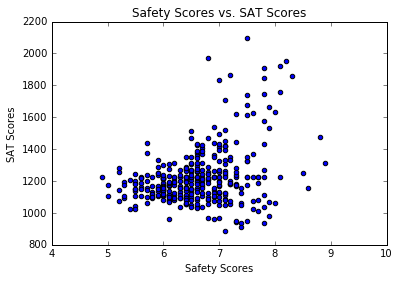

In [54]:
%matplotlib inline

plt.scatter(combined["saf_s_11"], combined["sat_score"])
plt.title("Safety Scores vs. SAT Scores")
plt.xlabel("Safety Scores")
plt.ylabel("SAT Scores")

This scatter plot gives a better understanding of the strong correlation score, but perhaps a false positive. There are a large amount of scores around 1200 that span saftey scores from 5 to 8. Then, around 6.5 we can see a slight upwards, linear trend beginning. The highest safety scores are above average SAT scores.. but not by a lot. 

This is still a very diverse grouping of data. Perhaps schools in Manhattan that feel safe are different than schools in Queens that feel safe.

I'll group by school district, average the safety scores by district, then map out where these "safe" and "unsafe" feeling schools are located. Perhaps that will explain this almost right angled trend in this chart. 

# Safety Ratings by School District

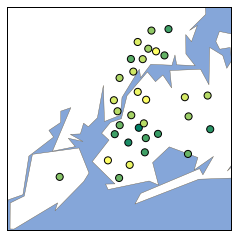

In [55]:
#group by school district and calculate means
district = combined.groupby('school_dist').agg(np.mean)
district.reset_index(inplace = True)

from mpl_toolkits.basemap import Basemap
#make base
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

#rivers and boundaries
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

#locations of schools
lon = district['lon'].tolist()
lat = district['lat'].tolist()

#plot
m.scatter(lon, lat, s =50, zorder = 2, cmap = "summer", 
       c = district["saf_s_11"], latlon=True)
plt.show()

Looking at a map of the New York Boroughs, Manhattan has a collection of medium-safe schools. Upper Brooklyn has the worst, but to the south, also has some of the best. Queens is similar, from West to East the schools become less safe. Bronx is evenly distributed, and Staten Island only has one, medium safe school.

# Race and SAT scores

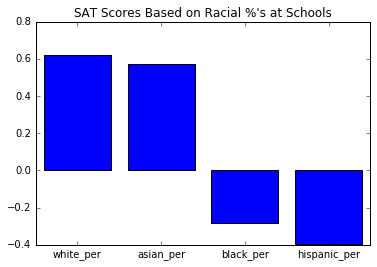

In [62]:
#Find the columns with racial percentages of each school
race = ["white_per", "asian_per", "black_per", "hispanic_per"]

#bar plot
pos = np.arange(len(race))
plt.bar(pos, correlations[race], align="center")
plt.xticks(pos, race)
plt.title("SAT Scores Based on Racial %'s at Schools")

This is quite a dramatic spread. There's a clear and incredibly strong correlation between White and Asian people doing well on the SAT. Black and Hispanic test takers will likely have lower scores. This may stem from an economic reason; SAT prep is a course that many White and Asian people take before sitting for the test. While extremely helpful, it's also a very expensive course. It could also be just general underfunding for more rural schools that happen to have higher percentages of Black and Hispanic students.

The hispanic correlation is a very strong negative. Let's look at why that might be. 

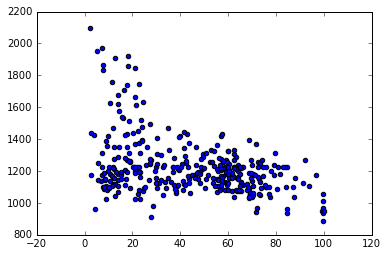

In [65]:
#Hispanic_per vs. SAT_score
plt.scatter(combined['hispanic_per'], combined['sat_score'])

There's a strong average around 1200 regardless of percentage of Hispanics at the school. However, there's a healthy amount of outliers where there are just under 20% of Hispanics and they range almost the whole specturum of Hispanic scores. 

In [66]:
print(combined[combined['hispanic_per'] > 95]['SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools with 95%+ of Hispanic attendance are geared towards recent immigrants. This explains the high percentage of Hispanics as well as the low sat scores; taking a test is a second (or multiple) language that is recently learned would dramatically reduce your writing and reading comprehension. 

In [81]:
print(combined[(combined["hispanic_per"]<10) & 
                (combined['sat_score'] > 1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


All of the above schools are a part of the "Specialized High Schools in NYC" grouping. Nine schools that are known for STEM and academic excellence. An entrance test is required to attend (as well as an application). It's no suprise that hispanic students that are admitted are good at test taking; they were chosen for their acedemic abilities and already proved it through taking a standardized test. 

# Gender and SAT Scores

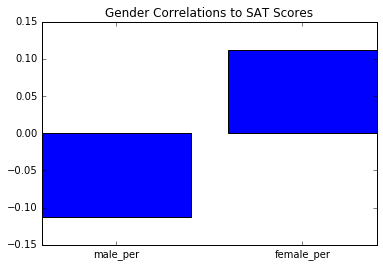

In [85]:
gender = ["male_per", "female_per"]

#bar plot
pos = np.arange(len(gender))
plt.bar(pos, correlations[gender], align = "center")
plt.xticks(pos, gender)
plt.title("Gender Correlations to SAT Scores")

I didn't expect this result. The percentage of women at a school correlates positively with high SAT scores. Let's try to find out why. 

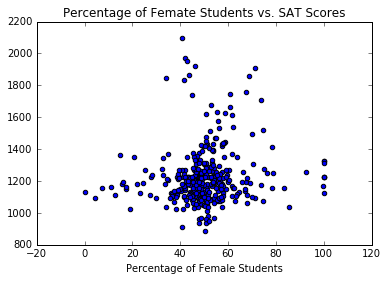

In [88]:
plt.scatter(combined["female_per"],combined["sat_score"])
plt.xlabel("Percentage of Female Students")
plt.title("Percentage of Femate Students vs. SAT Scores")

What a strange graph. It looks like the average is hovering around 1200 regardless if there are no women or only women. The best chance for a high SAT score comes when there is between 40 and 80% of female students. Perhaps the balance of genders is better for focusing on studying as opposed to the lack of another gender. 

But what sets those 15 odd schools with evenly balanced genders apart from the rest?

In [91]:
print(combined[(combined["female_per"]>60) & (combined["sat_score"] >1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools are all extremely competitive and require entrance exams. Often offering college credit, they only accept the highest achievers. It makes perfect sense that these schools are both balanced by gender, but have extremely high SAT scores compared to other balanced schools. 

# AP Exams and SAT Scores

To not be biased towards total enrollment (since it already has a strong correlation to sat_scores) I'm going to base this off of percentage of AP test takers in a school. 

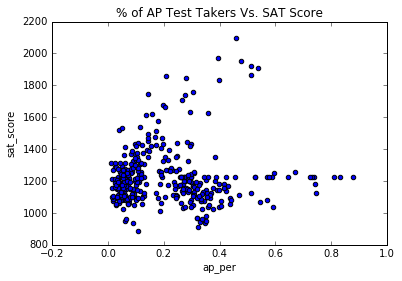

In [95]:
combined["ap_per"] = combined["AP Test Takers "]/combined["total_enrollment"]

#scatter plot
combined.plot.scatter("ap_per", "sat_score")
plt.title("% of AP Test Takers Vs. SAT Score")

This is an interesting graph; there's a clear glob around 10% takes and 1200 scores, but two distinct "legs". One represents more of the expected result; the higher percentage of AP Test Takers, the higher the SAT score. However the other leg is quite the opposite. Regardless of AP Test Takers, even a 90%!, the average 1200 is clearly adhered to. 

Appears to be some sort of correlation who's effect might be clouded by something I'm not accounting for. As is, it's not a strong or clear enough correlation